# Intro to Deep Learning Systems: Lab 4

In [1]:
import json
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import torch.nn as nn
from tqdm import tqdm
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision.io import read_image
from torchvision import transforms
from pathlib import Path

## Q1.1a
### Load Dataset

In [2]:
class DecalCIFAR100(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.data = self._make_dataset(img_dir, annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def _make_dataset(self, img_dir, annotations_file):
        with open(annotations_file) as f:
            self.meta_data = json.load(f)
            
        meta_img, meta_annot, meta_cat = pd.DataFrame(self.meta_data["images"]), self.meta_data["annotations"], self.meta_data["categories"]
        meta_img = meta_img.set_index("id")
        
        data = []
        for row in meta_annot:
            image, category = meta_img.loc[int(row["image_id"])]["file_name"], int(row["category_id"])
            img_path = Path(img_dir) / image.lstrip("data/")
            data.append({"File Path": img_path, "Label": int(category)})
        
        data = pd.DataFrame(data)
        
        min_cat = min(data["Label"])
        data["Label"] = data["Label"] - min_cat  # Categories from '20000001' onwards need to be standardized
        self.label_map = {int(row["id"]) - min_cat : row["name"] for row in meta_cat}
        self._l_data = len(data)
        return data

    def __len__(self):
        return self._l_data

    def __getitem__(self, idx):
        img_path, label = self.data.iloc[idx]
        image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# Data Paths
dataset_name = "cifar100"
annotations_path = Path("annotations")
train_annotations = annotations_path / f"{dataset_name}_train.json"
val_annotations = annotations_path / f"{dataset_name}_val.json"
test_annotations = annotations_path / f"{dataset_name}_test_stripped.json"
data_path = Path("data")

In [4]:
cifar100_train_ds = DecalCIFAR100(annotations_file=str(train_annotations), img_dir = str(data_path))
cifar100_val_ds = DecalCIFAR100(annotations_file=str(val_annotations), img_dir = str(data_path))
labels_map = cifar100_train_ds.label_map

### Describe Dataset

In [5]:
print(f"Dataset Name: {dataset_name}")
labels_df = pd.DataFrame([{"Label": label, "Class": name} for label, name in labels_map.items()])
cifar_df = cifar100_train_ds.data
class_df = pd.merge(cifar_df, labels_df, how="inner")

pd.set_option('display.max_rows', class_df.shape[0]+1)

class_counts = class_df["Class"].value_counts()
print(f"Number of classes: {class_counts.shape[0]}")
print(f"Image distribution per class:")
class_counts

Dataset Name: cifar100
Number of classes: 100
Image distribution per class:


apple            400
porcupine        400
shark            400
seal             400
sea              400
rose             400
rocket           400
road             400
ray              400
raccoon          400
rabbit           400
possum           400
poppy            400
aquarium_fish    400
plate            400
plain            400
pine_tree        400
pickup_truck     400
pear             400
palm_tree        400
otter            400
orchid           400
orange           400
oak_tree         400
shrew            400
skunk            400
skyscraper       400
snail            400
woman            400
wolf             400
willow_tree      400
whale            400
wardrobe         400
turtle           400
tulip            400
trout            400
train            400
tractor          400
tiger            400
television       400
telephone        400
tank             400
table            400
sweet_pepper     400
sunflower        400
streetcar        400
squirrel         400
spider       

In [6]:
pd.set_option('display.max_rows', 10)

### Sample Images

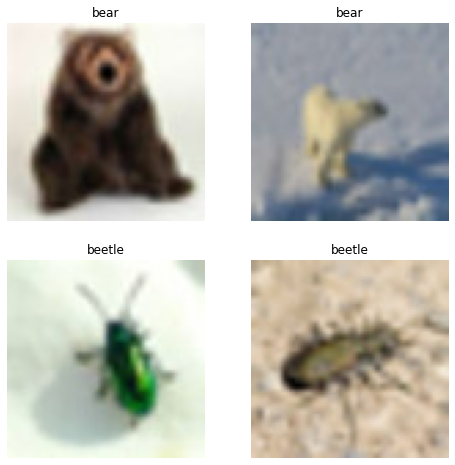

In [7]:
cols, rows = 2, 2
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
sample_labels = [3, 7]

for i in range(rows):
    sample_idx = list(cifar_df.index[cifar_df["Label"] == sample_labels[i]])[:2]
    for j, idx in enumerate(sample_idx):
        img, label = cifar100_train_ds[idx]
        axes[i][j].set_title(labels_map[label])
        axes[i][j].axis("off")
        axes[i][j].imshow(img.permute(1, 2, 0))
plt.show()

### Modify Pretrained Model

In [8]:
def fine_tune_model(base_model, initial_lr):
    model_ft = base_model
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 100)  # Set output features for full-connected layer to 100 (for cifar100)
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=initial_lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    n_epochs = 200
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=[60, 120, 180])
    
    model_ft = train_model(model_ft, criterion, optimizer_ft, lr_scheduler, num_epochs=n_epochs)
    
    return model_ft

## Q1.1b

In [8]:
# Params
batch_size = 64

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {"train": cifar100_train_ds, "val": cifar100_val_ds}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Finetune the model via training on CIFAR100

In [15]:
model_ft = fine_tune_model(models.resnet50(pretrained=True), 1e-3)

Epoch 0/199
----------
train Loss: 2.1094 Acc: 0.5003
val Loss: 1.1214 Acc: 0.6741
Epoch 1/199
----------
train Loss: 0.8510 Acc: 0.7491
val Loss: 0.9047 Acc: 0.7250
Epoch 2/199
----------
train Loss: 0.5080 Acc: 0.8502
val Loss: 0.8589 Acc: 0.7457
Epoch 3/199
----------
train Loss: 0.2957 Acc: 0.9158
val Loss: 0.8883 Acc: 0.7453
Epoch 4/199
----------
train Loss: 0.1706 Acc: 0.9568
val Loss: 0.8934 Acc: 0.7570
Epoch 5/199
----------
train Loss: 0.0965 Acc: 0.9797
val Loss: 0.9199 Acc: 0.7530
Epoch 6/199
----------
train Loss: 0.0578 Acc: 0.9900
val Loss: 0.9183 Acc: 0.7655
Epoch 7/199
----------
train Loss: 0.0373 Acc: 0.9948
val Loss: 0.9508 Acc: 0.7609
Epoch 8/199
----------
train Loss: 0.0258 Acc: 0.9971
val Loss: 0.9507 Acc: 0.7655
Epoch 9/199
----------
train Loss: 0.0195 Acc: 0.9979
val Loss: 0.9880 Acc: 0.7607
Epoch 10/199
----------
train Loss: 0.0157 Acc: 0.9984
val Loss: 0.9829 Acc: 0.7671
Epoch 11/199
----------
train Loss: 0.0129 Acc: 0.9987
val Loss: 0.9964 Acc: 0.7689
Ep

In [24]:
model_ft_lr001 = fine_tune_model(models.resnet50(pretrained=True), 1e-2)

Epoch 0/199
----------
train Loss: 1.9019 Acc: 0.4961
val Loss: 1.5573 Acc: 0.5761
Epoch 1/199
----------
train Loss: 1.0864 Acc: 0.6804
val Loss: 1.5169 Acc: 0.5895
Epoch 2/199
----------
train Loss: 0.7411 Acc: 0.7724
val Loss: 1.6037 Acc: 0.5859
Epoch 3/199
----------
train Loss: 0.5177 Acc: 0.8375
val Loss: 1.6026 Acc: 0.6174
Epoch 4/199
----------
train Loss: 0.4134 Acc: 0.8685
val Loss: 1.4997 Acc: 0.6405
Epoch 5/199
----------
train Loss: 0.3003 Acc: 0.9031
val Loss: 1.4532 Acc: 0.6580
Epoch 6/199
----------
train Loss: 0.2053 Acc: 0.9321
val Loss: 1.6098 Acc: 0.6509
Epoch 7/199
----------
train Loss: 0.1943 Acc: 0.9365
val Loss: 1.6219 Acc: 0.6514
Epoch 8/199
----------
train Loss: 0.1398 Acc: 0.9545
val Loss: 1.6400 Acc: 0.6646
Epoch 9/199
----------
train Loss: 0.1056 Acc: 0.9663
val Loss: 1.7133 Acc: 0.6581
Epoch 10/199
----------
train Loss: 0.0864 Acc: 0.9724
val Loss: 1.6729 Acc: 0.6720
Epoch 11/199
----------
train Loss: 0.0792 Acc: 0.9745
val Loss: 1.6223 Acc: 0.6802
Ep

In [11]:
model_ft_lr01 = fine_tune_model(models.resnet50(pretrained=True), 1e-1)

Epoch 0/199
----------
train Loss: 4.2531 Acc: 0.0512
val Loss: 3.8458 Acc: 0.0939
Epoch 1/199
----------
train Loss: 3.5627 Acc: 0.1449
val Loss: 3.3179 Acc: 0.1950
Epoch 2/199
----------
train Loss: 3.0721 Acc: 0.2380
val Loss: 3.5385 Acc: 0.1928
Epoch 3/199
----------
train Loss: 2.7175 Acc: 0.3083
val Loss: 2.7076 Acc: 0.3205
Epoch 4/199
----------
train Loss: 2.4128 Acc: 0.3717
val Loss: 2.6859 Acc: 0.3293
Epoch 5/199
----------
train Loss: 2.1280 Acc: 0.4327
val Loss: 2.4619 Acc: 0.3729
Epoch 6/199
----------
train Loss: 1.8894 Acc: 0.4862
val Loss: 2.6391 Acc: 0.3556
Epoch 7/199
----------
train Loss: 1.6004 Acc: 0.5565
val Loss: 2.3051 Acc: 0.4171
Epoch 8/199
----------
train Loss: 1.3264 Acc: 0.6215
val Loss: 2.5314 Acc: 0.3901
Epoch 9/199
----------
train Loss: 1.0990 Acc: 0.6782
val Loss: 2.5144 Acc: 0.4149
Epoch 10/199
----------
train Loss: 0.7793 Acc: 0.7668
val Loss: 2.7669 Acc: 0.3984
Epoch 11/199
----------
train Loss: 0.5284 Acc: 0.8409
val Loss: 2.7259 Acc: 0.4180
Ep

## Q1.1c

In [15]:
model_ext_1 = transfer_learn(models.resnet50(pretrained=True), 1, fixed_extract=True)

Epoch 0/199
----------
train Loss: 95.6782 Acc: 0.3253
val Loss: 86.7004 Acc: 0.3904
Epoch 1/199
----------
train Loss: 75.3866 Acc: 0.4243
val Loss: 86.7201 Acc: 0.4063
Epoch 2/199
----------
train Loss: 70.5082 Acc: 0.4592
val Loss: 89.3746 Acc: 0.4142
Epoch 3/199
----------
train Loss: 68.1898 Acc: 0.4763
val Loss: 88.3023 Acc: 0.4329
Epoch 4/199
----------
train Loss: 63.7868 Acc: 0.4968
val Loss: 84.4346 Acc: 0.4497
Epoch 5/199
----------
train Loss: 59.9139 Acc: 0.5145
val Loss: 84.5138 Acc: 0.4583
Epoch 6/199
----------
train Loss: 57.8107 Acc: 0.5279
val Loss: 86.1414 Acc: 0.4591
Epoch 7/199
----------
train Loss: 54.6106 Acc: 0.5405
val Loss: 85.1672 Acc: 0.4603
Epoch 8/199
----------
train Loss: 53.3362 Acc: 0.5495
val Loss: 88.9887 Acc: 0.4475
Epoch 9/199
----------
train Loss: 51.6701 Acc: 0.5601
val Loss: 89.6850 Acc: 0.4524
Epoch 10/199
----------
train Loss: 49.1187 Acc: 0.5703
val Loss: 86.2470 Acc: 0.4636
Epoch 11/199
----------
train Loss: 47.4769 Acc: 0.5792
val Loss

In [16]:
model_ext_01 = transfer_learn(models.resnet50(pretrained=True), 1e-1, fixed_extract=True)

Epoch 0/199
----------
train Loss: 7.3371 Acc: 0.3424
val Loss: 8.1837 Acc: 0.3894
Epoch 1/199
----------
train Loss: 6.8430 Acc: 0.4296
val Loss: 8.0081 Acc: 0.4221
Epoch 2/199
----------
train Loss: 6.5457 Acc: 0.4605
val Loss: 8.1770 Acc: 0.4300
Epoch 3/199
----------
train Loss: 6.0011 Acc: 0.4920
val Loss: 7.4979 Acc: 0.4478
Epoch 4/199
----------
train Loss: 5.7492 Acc: 0.5071
val Loss: 7.6863 Acc: 0.4475
Epoch 5/199
----------
train Loss: 5.3600 Acc: 0.5260
val Loss: 7.6726 Acc: 0.4473
Epoch 6/199
----------
train Loss: 5.2196 Acc: 0.5380
val Loss: 8.1886 Acc: 0.4548
Epoch 7/199
----------
train Loss: 5.0373 Acc: 0.5477
val Loss: 7.8364 Acc: 0.4546
Epoch 8/199
----------
train Loss: 4.6915 Acc: 0.5644
val Loss: 8.1826 Acc: 0.4632
Epoch 9/199
----------
train Loss: 4.5912 Acc: 0.5711
val Loss: 7.8632 Acc: 0.4612
Epoch 10/199
----------
train Loss: 4.4191 Acc: 0.5822
val Loss: 8.5232 Acc: 0.4598
Epoch 11/199
----------
train Loss: 4.1065 Acc: 0.5962
val Loss: 7.8866 Acc: 0.4727
Ep

In [17]:
model_ext_001 = transfer_learn(models.resnet50(pretrained=True), 1e-2, fixed_extract=True)

Epoch 0/199
----------
train Loss: 2.3463 Acc: 0.4149
val Loss: 1.9821 Acc: 0.4810
Epoch 1/199
----------
train Loss: 1.8137 Acc: 0.5178
val Loss: 1.9328 Acc: 0.4990
Epoch 2/199
----------
train Loss: 1.6626 Acc: 0.5530
val Loss: 1.8915 Acc: 0.5086
Epoch 3/199
----------
train Loss: 1.5740 Acc: 0.5703
val Loss: 1.8358 Acc: 0.5196
Epoch 4/199
----------
train Loss: 1.5034 Acc: 0.5874
val Loss: 1.8870 Acc: 0.5157
Epoch 5/199
----------
train Loss: 1.4404 Acc: 0.6017
val Loss: 1.8783 Acc: 0.5216
Epoch 6/199
----------
train Loss: 1.4037 Acc: 0.6112
val Loss: 1.8942 Acc: 0.5213
Epoch 7/199
----------
train Loss: 1.3489 Acc: 0.6210
val Loss: 1.8475 Acc: 0.5216
Epoch 8/199
----------
train Loss: 1.3168 Acc: 0.6285
val Loss: 1.8444 Acc: 0.5289
Epoch 9/199
----------
train Loss: 1.2709 Acc: 0.6406
val Loss: 1.8821 Acc: 0.5235
Epoch 10/199
----------
train Loss: 1.2375 Acc: 0.6466
val Loss: 1.8587 Acc: 0.5264
Epoch 11/199
----------
train Loss: 1.2062 Acc: 0.6528
val Loss: 1.8883 Acc: 0.5270
Ep

In [18]:
model_ext_0001 = transfer_learn(models.resnet50(pretrained=True), 1e-3, fixed_extract=True)

Epoch 0/199
----------
train Loss: 3.3472 Acc: 0.3069
val Loss: 2.5556 Acc: 0.4314
Epoch 1/199
----------
train Loss: 2.3321 Acc: 0.4624
val Loss: 2.1791 Acc: 0.4669
Epoch 2/199
----------
train Loss: 2.0700 Acc: 0.4919
val Loss: 2.0523 Acc: 0.4815
Epoch 3/199
----------
train Loss: 1.9362 Acc: 0.5126
val Loss: 1.9673 Acc: 0.4937
Epoch 4/199
----------
train Loss: 1.8450 Acc: 0.5285
val Loss: 1.9178 Acc: 0.5022
Epoch 5/199
----------
train Loss: 1.7805 Acc: 0.5409
val Loss: 1.8887 Acc: 0.5079
Epoch 6/199
----------
train Loss: 1.7337 Acc: 0.5497
val Loss: 1.8546 Acc: 0.5108
Epoch 7/199
----------
train Loss: 1.6972 Acc: 0.5566
val Loss: 1.8211 Acc: 0.5186
Epoch 8/199
----------
train Loss: 1.6615 Acc: 0.5631
val Loss: 1.8300 Acc: 0.5139
Epoch 9/199
----------
train Loss: 1.6305 Acc: 0.5679
val Loss: 1.8122 Acc: 0.5166
Epoch 10/199
----------
train Loss: 1.6048 Acc: 0.5760
val Loss: 1.7982 Acc: 0.5222
Epoch 11/199
----------
train Loss: 1.5842 Acc: 0.5802
val Loss: 1.7862 Acc: 0.5263
Ep